# Tikz

The `tikz` Linux package is a *TeX* package for creating graphics programmatically.

From the *Cell* menu, select *Run All* to run the hidden code cells and render the gnerated output content.

VIew hidden code by selecting a hidden code cell and selecting the *Toggle selected cell input display* button on the toolbar, or toggle the display of all code cell inputs.

In [1]:
#via https://github.com/robjstan/tikzmagic
import subprocess
import shlex
import shutil
import tempfile
from argparse import ArgumentParser
from base64 import b64encode
from os.path import isfile
from os import getcwd

from IPython.core.magic import register_line_cell_magic
from IPython.core.display import Image

In [2]:
import base64
from IPython.core.display import HTML

LATEX_TEMPLATE = r'''
\documentclass[tikz,border={border}]{{standalone}}
\usepackage{{tikz,{latex_pkgs}}}
\usetikzlibrary{{{tikz_libs}}}
{latex_pre}
\begin{{document}}
{content}
\end{{document}}'''

@register_line_cell_magic
def tikz(line, cell=''):
    '''Format TikZ commands into a LaTeX document, compile, and convert.'''
    parser = ArgumentParser()
    parser.add_argument('-p', '--latex_packages', default='')
    parser.add_argument('-x', '--latex_preamble', default='')
    parser.add_argument('-l', '--tikz_libraries', default='')
    parser.add_argument('-i', '--input_file', default=None)
    parser.add_argument('-e', '--export_file', default=None)
    parser.add_argument('-s', '--scale', default=1, type=float)
    parser.add_argument('-b', '--border', default=4)
    parser.add_argument('--wrap', dest='wrap_env', action='store_true')
    parser.add_argument('--no-wrap', dest='wrap_env', action='store_false')
    parser.set_defaults(wrap_env=True)
    parser.add_argument('--debug', dest='debug_mode', action='store_true')
    parser.set_defaults(debug_mode=False)
    args = parser.parse_args(shlex.split(line))

    # prepare latex from template
    if args.input_file:
        # add content from input_file before rest of cell
        cell += r'\input{{{cwd}/{file}}}'.format(cwd=getcwd(),
                                                 file=args.input_file)

    if args.wrap_env:
        cell = r'\begin{tikzpicture}' + cell + r'\end{tikzpicture}'

    latex = LATEX_TEMPLATE.format(content=cell,
                                  border=args.border,
                                  latex_pre=args.latex_preamble,
                                  latex_pkgs=args.latex_packages,
                                  tikz_libs=args.tikz_libraries)

    if args.debug_mode:
        print(latex)

    # add current working directory to any export_file path
    if args.export_file:
        args.export_file = getcwd() + '/' + args.export_file

    # compile and convert, returning Image data
    return latex2image(latex, int(args.scale*300), args.export_file)

def latex2image(latex, density, export_file=None):
    '''Compile LaTeX to PDF, and convert to PNG.'''
    try:
        # make a temp directory, and name temp files
        temp_dir = tempfile.mkdtemp()
        temp_tex = temp_dir + '/tikzfile.tex'
        temp_pdf = temp_dir + '/tikzfile.pdf'
        temp_png = temp_dir + '/tikzfile.png'

        open(temp_tex, 'w').write(latex)
        # run LaTeX to generate a PDF
        sh_latex(in_file=temp_tex, out_dir=temp_dir)

        if not isfile(temp_pdf):
            raise Exception('pdflatex did not produce a PDF file.')

        if export_file:
            shutil.copyfile(temp_pdf, export_file)

         # convert PDF to PNG
        sh_convert(in_file=temp_pdf, out_file=temp_png, density=density)
        
        #The Image(data=png) thing doesn't work..?
        png = b64encode(open(temp_png, "rb").read())
        #return Image(data=png)
        return Image(filename=temp_png)
        
    finally:
        # remove temp directory
        shutil.rmtree(temp_dir)

# functions to run command line scripts
def sh_latex(in_file, out_dir):
    '''Compile XeLaTeX to generate a PDF.'''
    subprocess.call(['xelatex', '-output-directory', out_dir, in_file])

def sh_convert(in_file, out_file, density=96):
    '''Use ImageMagick to convert PDF to PNG.'''
    subprocess.call(['convert', '-density', str(density), in_file, out_file])

def load_ipython_extension(ipython):
    '''Load iPython extension. Empty as we don't need to do anything.'''
    pass

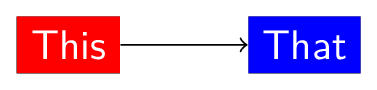

In [5]:
%%tikz 
\tikzset{every node/.style={font=\sffamily,white}}

\node[fill=red] at (0,0) (a) {This};
\node[fill=blue] at (2,0) (b) {That};
\draw[->] (a) -- (b);

### tikZ Examples

Via https://tex.stackexchange.com/questions/158668/nice-scientific-pictures-show-off

May require additional Latex packages to be installed?